In [70]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn

import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# GLOBAL VARS
preprocess = True
check = False
# Put on False for full training set
training_size = 5000
epochs = 12
learning_rate = 3e-3

In [50]:
script_dir = os.getcwd()
face_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model.eval()

for p in face_model.parameters():
    p.requires_grad = False   # frozen

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [51]:
class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=3):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, faces):
        """
        faces: list or tensor of up to 3 face tensors, each (3,224,224)
        returns: tensor of shape (7*max_faces,) = (21,)
        """
        if isinstance(faces, list):
            faces = [f for f in faces if torch.is_tensor(f)]
            if len(faces) == 0:
                dummy = torch.zeros(3,224,224, device=next(self.hf_model.parameters()).device)
                faces = [dummy]
            faces = faces[:self.max_faces]
            face_batch = torch.stack(faces, dim=0)
        elif faces.ndim == 3:
            face_batch = faces.unsqueeze(0)
        else:
            face_batch = faces

        with torch.no_grad():
            out = self.hf_model(face_batch)
            logits = out.logits                   # (n_faces,7)
        
        # pad to max_faces
        if logits.size(0) < self.max_faces:
            pad = torch.zeros(self.max_faces - logits.size(0), 7, device=logits.device)
            logits = torch.cat([logits, pad], dim=0)
        return logits                            # (3,7)


In [52]:
multi_face_net = MultiFaceWrapperFlat(face_model, max_faces=3)

In [53]:
class GateMLP(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=4, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return torch.softmax(self.net(x), dim=-1)


In [54]:
gate_net = GateMLP(in_dim=12, hidden=64, out_dim=4)

In [55]:
# ==============================================================
# 1. CONFIG
# ==============================================================

# Paths
script_dir = os.getcwd()
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
labels_dir = os.path.join(base_findingemo_dir, "labels")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Emotion mapping (FindingEmo → 7 basic emotions)
FindingEmo_to_basic = {
    "Anger": 0, "Rage": 0, "Annoyance": 0,
    "Loathing": 1, "Disgust": 1,
    "Apprehension": 2, "Fear": 2, "Terror": 2,
    "Joy": 3, "Serenity": 3, "Ecstasy": 3, "Admiration": 3,
    "Grief": 4, "Sadness": 4, "Pensiveness": 4,
    "Amazement": 5, "Surprise": 5,
    "Trust": 6, "Interest": 6, "Boredom": 6, "Acceptance": 6, "Distraction": 6
}

# Load CSV
df = pd.read_csv(csv_path)
df["idx_emotion"] = df["emotion"].map(FindingEmo_to_basic)
df = df.dropna(subset=["idx_emotion"]).reset_index(drop=True)
df["idx_emotion"] = df["idx_emotion"].astype(int)

In [56]:
def is_image_valid(row):
    """Check if an image can be loaded without errors"""
    img_path = os.path.join(base_findingemo_dir, row['image_path'])
    
    if not os.path.exists(img_path):
        return False
    
    try:
        # Try loading with PIL (simpler)
        img = Image.open(img_path).convert("RGB")
        return True
    except Exception:
        return False

if check:
    # Filter out invalid images
    print(f"Original dataset size: {len(df)}")
    valid_mask = df.apply(is_image_valid, axis=1)
    df_clean = df[valid_mask].reset_index(drop=True)
    print(f"Clean dataset size: {len(df_clean)}")
    print(f"Removed {len(df) - len(df_clean)} corrupted images")

    # Save the cleaned dataframe, overwriting the original
    df_clean.to_csv(csv_path, index=False)
    print(f"Saved cleaned dataset to: {csv_path}")

    # Update your main dataframe
    df = df_clean

# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

Original dataset size: 18713


c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Clean dataset size: 18711
Removed 2 corrupted images
Saved cleaned dataset to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\../data/findingemo\labels\annotations_cleaned.csv


In [57]:
scene_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)
scene_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scene_model.to(device)

# precompute the 365 logits
scene_logits_save_dir = '../data/places365/precomputed/logits/'

def preprocess_scene_logits(save_dir, subset):
    save_dir = os.path.join(save_dir, subset)

    if subset == "train":
        data = train_df
    else:
        data = test_df

    with torch.no_grad():
        for i, row in tqdm(data.iterrows(), total=len(data)):
            img_path = os.path.join(base_findingemo_dir, row['image_path'])
            if not os.path.exists(img_path):
                continue
            try:
                img = Image.open(img_path).convert("RGB")
                x = scene_tf(img).unsqueeze(0).to(device)
                logits = scene_model(x).squeeze(0).cpu()
                torch.save(logits, os.path.join(save_dir, f"{i}.pt"))
            except Exception as e:
                print(f"Error processing on index {i} on the {subset} set. Path: {img_path}: {e}")
                continue

if preprocess:
    preprocess_scene_logits(save_dir=scene_logits_save_dir, subset="train")
    preprocess_scene_logits(save_dir=scene_logits_save_dir, subset="test")

  1%|          | 181/14968 [00:10<11:46, 20.94it/s]c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 17%|█▋        | 651/3743 [00:47<03:52, 13.32it/s]c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3743/3743 [03:15<00:00, 19.18it/s]


In [67]:
# Load category names
scene_categories_path = os.path.join(script_dir, "../data/places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]

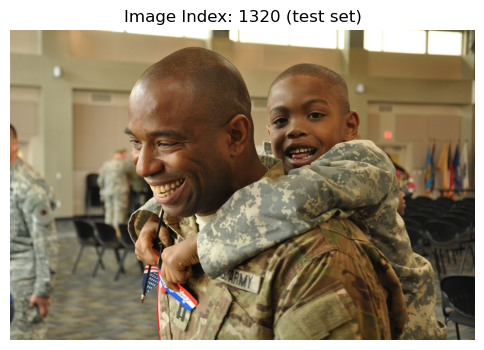

Top 5 scene categories for index 1320 in test set:
army_base: 97.21%
nursing_home: 0.61%
veterinarians_office: 0.61%
science_museum: 0.25%
hospital_room: 0.24%


In [ ]:
def inspect_scene_logits(idx, subset):
    if subset == "train":
        data = train_df
    else:
        data = test_df

    logits_path = os.path.join(scene_logits_save_dir, subset, f"{idx}.pt")
    if not os.path.exists(logits_path):
        print(f"Logits file does not exist: {logits_path}")
        return

    logits = torch.load(logits_path)
    top5_prob, top5_catid = torch.topk(torch.softmax(logits, dim=0), 5)

    # Display corresponding image
    img_path = os.path.join(base_findingemo_dir, data.loc[idx, 'image_path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image Index: {idx} ({subset} set)")
    plt.axis('off')
    plt.show()
    
    print(f"Top 5 scene categories for index {idx} in {subset} set:")
    for i in range(top5_prob.size(0)):
        print(f"{scene_categories[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

inspect_scene_logits(idx = np.random.randint(0, len(test_df)), subset="test")

In [ ]:
class SceneFeaturesDataset(Dataset):
    def __init__(self, df, feature_dir):
        self.df = df
        self.feature_dir = feature_dir
    def __getitem__(self, idx):
        z = torch.load(os.path.join(self.feature_dir, f"{idx}.pt"))  # (365,)
        y = torch.tensor(self.df.iloc[idx]["idx_emotion"], dtype=torch.long)
        return z, y
    def __len__(self):
        return len(self.df)

dataset = SceneFeaturesDataset(df, os.path.join(base_findingemo_dir, "precomputed/scenes"))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [50]:
# ==============================================================
# 3. MODEL: Places365 → Emotion Adapter
# ==============================================================

# Load pretrained Places365 backbone
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)
scene_model.eval()
for p in scene_model.parameters():
    p.requires_grad = False  # freeze entire backbone


# Adapter layer 365 → 7
class SceneToEmotionAdapter(nn.Module):
    def __init__(self, base_scene_model, num_places=365, num_emotions=7):
        super().__init__()
        self.scene_model = base_scene_model
        self.fc = nn.Linear(num_places, num_emotions)
        nn.init.kaiming_uniform_(self.fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        with torch.no_grad():  # freeze Places365 backbone
            place_logits = self.scene_model(x)
        emo_logits = self.fc(place_logits)
        return emo_logits


scene_net = SceneToEmotionAdapter(scene_model).to(device)

In [ ]:
# ==============================================================
# 4. TRAINING
# ==============================================================

optimizer = optim.Adam(scene_net.fc.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
for epoch in range(3):  # few epochs are enough
    scene_net.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = scene_net(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    scene_net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = scene_net(imgs)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(scene_net.state_dict(), "scene_to_emotion_best.pth")
        print("Saved new best model.")

Epoch 1 [Train]:   0%|          | 0/468 [00:00<?, ?it/s]

In [ ]:
# ==============================================================
# 5. PRECOMPUTE SCENE LOGITS FOR DEEPPROBLOG
# ==============================================================

scene_net.eval()
save_dir_train = os.path.join(base_findingemo_dir, "precomputed/scene_logits/train")
save_dir_test  = os.path.join(base_findingemo_dir, "precomputed/scene_logits/test")
os.makedirs(save_dir_train, exist_ok=True)
os.makedirs(save_dir_test, exist_ok=True)

def precompute_and_save(df, dataset, save_dir):
    with torch.no_grad():
        for i in tqdm(range(len(df)), desc=f"Saving {save_dir}"):
            img, _ = dataset[i]
            z = scene_net(img.unsqueeze(0).to(device))  # (1,7)
            torch.save(z.squeeze(0).cpu(), os.path.join(save_dir, f"{i}.pt"))


precompute_and_save(train_df, train_dataset, save_dir_train)
precompute_and_save(val_df,   val_dataset,   save_dir_test)

print("Done! Scene logits saved for DeepProbLog use.")


['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Grief', 'Serenity', 'Boredom', 'Ecstasy', 'Fear', 'Vigilance', 'Sadness', 'Rage', 'Annoyance', 'Acceptance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Admiration', 'Loathing', 'Distraction', 'Disgust']


,image_path,valence,arousal,emotion,idx_emotion
21366,Run_2/Comforting soldiers conference/article-2...,-1,4,Ecstasy,3
21368,Run_2/Compassionate seniors school/Leader-1-19...,0,4,Interest,6
21369,Run_2/Satisfied students desert/justin-w-01.jpg,0,2,Admiration,3
21370,Run_2/Disgusted forty-something funeral/126268...,0,3,Acceptance,6
21371,Run_2/Irritated soldiers army/kscn0008.jpg,1,4,Pensiveness,4


In [ ]:
# Train the scene net
# Split
from sklearn.model_selection import train_test_split
train_s2e, val_s2e = train_test_split(df_findingEmo, test_size=0.2, random_state=42)
train_s2e, val_s2e = train_s2e.reset_index(drop=True), val_s2e.reset_index(drop=True)

scene_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [26]:
class MoENet(nn.Module):
    def __init__(self, face_net, scene_net, gate_net):
        super().__init__()
        # These are here so you *can* (optionally) run them inside MoENet
        # and have their parameters updated end-to-end.
        self.face_net  = face_net
        self.scene_net = scene_net
        self.gate_net  = gate_net

    def forward(self, z_face, z_scene, face_present, num_faces):
        # 1) logits -> probabilities (per last dim = emotion classes)
        p_face  = torch.softmax(z_face, dim=-1)   # (B, 3, 7)
        p_face = p_face * face_present.unsqueeze(-1)  # mask out missing ones
        p_scene = torch.softmax(z_scene, dim=-1)  # (B, 7)

        # 2) Gate features (confidence signals)
        # Per-face max prob -> (B,3)
        max_face  = p_face.max(dim=-1).values

        # Per-face entropy -> (B,3)
        # H(p) = -sum_k p_k log p_k
        ent_face  = -(p_face.clamp_min(1e-12) * p_face.clamp_min(1e-12).log()).sum(dim=-1)

        # Scene max prob -> (B,)
        max_scene = p_scene.max(dim=-1).values

        # Scene entropy -> (B,)
        ent_scene = -(p_scene.clamp_min(1e-12) * p_scene.clamp_min(1e-12).log()).sum(dim=-1)

        # 3) Concatenate into one gate feature vector per sample
        # Shapes to concat along dim=-1:
        #   max_face:     (B,3)
        #   ent_face:     (B,3)
        #   max_scene:    (B,) -> unsqueeze -> (B,1)
        #   ent_scene:    (B,) -> unsqueeze -> (B,1)
        #   face_present: (B,3)  (0/1 per face slot)
        #   num_faces:    (B,1)
        gate_feats = torch.cat([
            max_face,                       # (B,3)
            ent_face,                       # (B,3)
            max_scene.unsqueeze(-1),        # (B,1)
            ent_scene.unsqueeze(-1),        # (B,1)
            face_present.float(),           # (B,3)
            num_faces.float()               # (B,1)
        ], dim=-1)                          # total per sample: 3+3+1+1+3+1 = 12 dims

        # 4) Gate net maps features -> 4 mixing weights (faces 0,1,2, scene)
        # Make sure your gate_net ends with a Softmax(dim=-1) so weights are >=0 and sum to 1.
        w = self.gate_net(gate_feats)       # (B,4)

        # 5) Weighted mixture of the 4 expert distributions
        # p_face[:,0]: (B,7) = face0 distribution; etc.
        # p_scene:      (B,7) = scene distribution
        p_mix = (
            w[:,0].unsqueeze(-1) * p_face[:,0] +   # weight face 0
            w[:,1].unsqueeze(-1) * p_face[:,1] +   # weight face 1
            w[:,2].unsqueeze(-1) * p_face[:,2] +   # weight face 2
            w[:,3].unsqueeze(-1) * p_scene         # weight scene
        )
        # (Optional) Re-normalize defensively (should already sum to 1 if w sums to 1)
        p_mix = p_mix / p_mix.sum(dim=-1, keepdim=True).clamp_min(1e-12)
        return p_mix                           # (B,7)

In [27]:
moe_model = MoENet(multi_face_net, scene_net, gate_net)

NameError: name 'scene_net' is not defined

In [ ]:
# train_test split
from sklearn.model_selection import train_test_split
# Shuffle the dataset
df_findingEmo = df_findingEmo.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

if training_size != False:
    train_df = train_df.iloc[:training_size]